In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings("ignore")

In [2]:

# Model Configuration
model_name = "t5-small"
TOKENIZER = T5Tokenizer.from_pretrained(model_name)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL = T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
MODEL.to(DEVICE)

# Training Parameters
Q_LEN = 512
T_LEN = 256  # Increased to accommodate answer + distractors
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-4
OUTPUT_DIR = './models/'
OUTPUT_MODEL_NAME = 'T5--mcq-generation'

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
def prepare_data(csv_path):
    df = pd.read_csv(csv_path)
    # Format distractors as comma-separated string if they're not already
    df['Distractors'] = df['Distractors'].apply(lambda x: x if isinstance(x, str) else ', '.join(x) if isinstance(x, list) else str(x))
    
    # Combine correct answer and distractors with special tokens
    df['target_text'] = df.apply(lambda row: f"<answer>{row['Correct Answer']}</answer><distractors>{row['Distractors']}</distractors>", axis=1)
    
    # Format input text with context and question
    df['input_text'] = 'Generate a multiple-choice question (MCQ) based on the given question and context. Ensure the output includes one correct answer and three unique incorrect answers (distractors).   Question: ' + df['Question'] + ' Context: ' + df['Context']
    
    # Print the first 5 formatted examples
    print("\nFirst 5 formatted examples:")
    print("-" * 80)
    for idx in range(min(5, len(df))):
        print(f"\nExample {idx + 1}:")
        print(f"Input text:\n{df['input_text'].iloc[idx]}")
        print(f"\nTarget text:\n{df['target_text'].iloc[idx]}")
        print("-" * 80)
    
    return df[['input_text', 'target_text']]

In [4]:
#  Custom Dataset class
class MCQGenerationDataset(Dataset):
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.inputs = dataframe['input_text'].values
        self.targets = dataframe['target_text'].values
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = str(self.inputs[idx])
        target_text = str(self.targets[idx])
        
        # Tokenize inputs
        input_encodings = self.tokenizer(input_text, 
                                       max_length=self.q_len,
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors="pt")
        
        # Tokenize targets
        target_encodings = self.tokenizer(target_text,
                                        max_length=self.t_len,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors="pt")
        
        labels = target_encodings['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': labels.squeeze(),
            'decoder_attention_mask': target_encodings['attention_mask'].squeeze()
        }


In [5]:
# Training function remains the same as your original code
def train_model(train_loader, val_loader, model, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batch_count = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            decoder_attention_mask = batch['decoder_attention_mask'].to(DEVICE)
            
            outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask)
            
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batch_count += 1
        
        avg_train_loss = train_loss / train_batch_count
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                decoder_attention_mask = batch['decoder_attention_mask'].to(DEVICE)
                
                outputs = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              decoder_attention_mask=decoder_attention_mask)
                
                val_loss += outputs.loss.item()
                val_batch_count += 1
        
        avg_val_loss = val_loss / val_batch_count
        val_losses.append(avg_val_loss)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Average validation loss: {avg_val_loss:.4f}")
        
    return train_losses, val_losses

In [6]:
# Modified generation function for MCQ
def generate_mcq(model, tokenizer, question, context, max_length=256):
    input_text = f"Generate MCQ options: Question: {question} Context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(DEVICE)
    
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Parse the generated text to extract answer and distractors
    try:
        answer = generated_text.split("<answer>")[1].split("</answer>")[0].strip()
        distractors = generated_text.split("<distractors>")[1].split("</distractors>")[0].strip()
        return {"correct_answer": answer, "distractors": distractors.split(", ")}
    except:
        return {"correct_answer": "", "distractors": []}


First 5 formatted examples:
--------------------------------------------------------------------------------

Example 1:
Input text:
Generate MCQ options: Question: What was the purpose of the Great Wall of China? Context: The Great Wall of China is one of the longest walls in the world. It was built to protect Chinese states from invasions.

Target text:
<answer>To protect from invasions</answer><distractors>To store water, To hold ceremonies, To trade goods</distractors>
--------------------------------------------------------------------------------

Example 2:
Input text:
Generate MCQ options: Question: What is the Sun? Context: The Sun is a star at the center of our solar system. It provides light and heat to Earth.

Target text:
<answer>A star</answer><distractors>A planet, A comet, A moon</distractors>
--------------------------------------------------------------------------------

Example 3:
Input text:
Generate MCQ options: Question: Where is Mount Everest located? Context: 

Validation Epoch 1/10: 100%|██████████| 170/170 [00:30<00:00,  5.53it/s]


Epoch 1/10
Average training loss: 1.5768
Average validation loss: 1.1735


Validation Epoch 2/10: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]


Epoch 2/10
Average training loss: 1.2333
Average validation loss: 1.1096


Validation Epoch 3/10: 100%|██████████| 170/170 [00:30<00:00,  5.53it/s]


Epoch 3/10
Average training loss: 1.1461
Average validation loss: 1.0735


Validation Epoch 4/10: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]


Epoch 4/10
Average training loss: 1.0797
Average validation loss: 1.0480


Validation Epoch 5/10: 100%|██████████| 170/170 [00:30<00:00,  5.53it/s]


Epoch 5/10
Average training loss: 1.0327
Average validation loss: 1.0323


Validation Epoch 6/10: 100%|██████████| 170/170 [00:30<00:00,  5.56it/s]


Epoch 6/10
Average training loss: 0.9866
Average validation loss: 1.0226


Validation Epoch 7/10: 100%|██████████| 170/170 [00:30<00:00,  5.58it/s]


Epoch 7/10
Average training loss: 0.9547
Average validation loss: 1.0184


Validation Epoch 8/10: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]


Epoch 8/10
Average training loss: 0.9229
Average validation loss: 1.0145


Validation Epoch 9/10: 100%|██████████| 170/170 [00:30<00:00,  5.57it/s]


Epoch 9/10
Average training loss: 0.8976
Average validation loss: 1.0096


Validation Epoch 10/10: 100%|██████████| 170/170 [00:30<00:00,  5.53it/s]


Epoch 10/10
Average training loss: 0.8820
Average validation loss: 1.0004


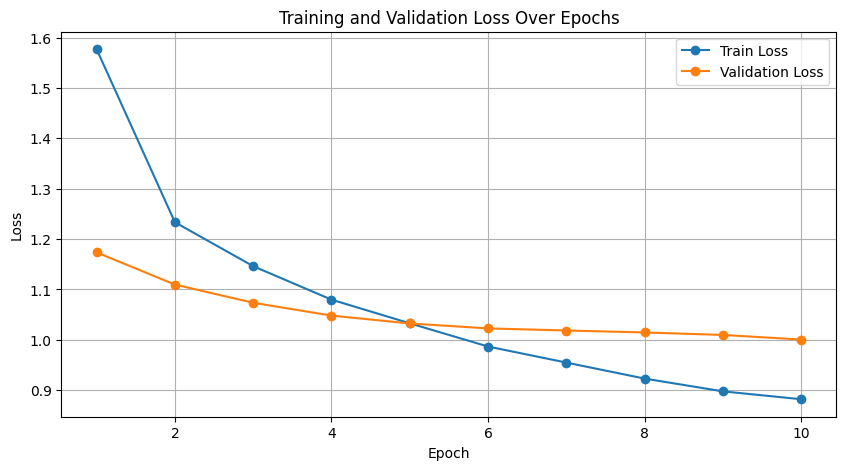


Sample Generation:
Question: What is the largest ocean on Earth?
Context: The Pacific Ocean is the largest and deepest ocean on Earth. It covers more than 63 million square miles.
Correct Answer: 
Distractors: 


In [7]:

def main():
    # Load and prepare data
    data = prepare_data('/kaggle/input/quizard-mcq-3000/Quizard_MCQ_3000.csv')
    
    # Split data
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = MCQGenerationDataset(TOKENIZER, train_data, Q_LEN, T_LEN)
    val_dataset = MCQGenerationDataset(TOKENIZER, val_data, Q_LEN, T_LEN)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize optimizer and scheduler
    optimizer = Adam(MODEL.parameters(), lr=LEARNING_RATE)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    
    # Train the model
    train_losses, val_losses = train_model(train_loader, val_loader, MODEL, optimizer, scheduler, EPOCHS)
    
    # Plot training results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Save the model
    MODEL.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
    TOKENIZER.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
    
    # Test the model
    sample_question = "What is the largest ocean on Earth?"
    sample_context = "The Pacific Ocean is the largest and deepest ocean on Earth. It covers more than 63 million square miles."
    
    generated_mcq = generate_mcq(MODEL, TOKENIZER, sample_question, sample_context)
    print("\nSample Generation:")
    print(f"Question: {sample_question}")
    print(f"Context: {sample_context}")
    print(f"Correct Answer: {generated_mcq['correct_answer']}")
    print(f"Distractors: {', '.join(generated_mcq['distractors'])}")

if __name__ == "__main__":
    main()

In [8]:
from kaggle_secrets import UserSecretsClient

# Retrieve the Hugging Face API token from Kaggle secrets
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [ ]:
# Save the fine-tuned model and tokenizer locally
MODEL.save_pretrained("T5-Test1MCQ-Quizard-10")
TOKENIZER.save_pretrained("T5-Test1MCQ-Quizard-10")

('T5-Test1MCQ-Quizard-10/tokenizer_config.json',
 'T5-Test1MCQ-Quizard-10/special_tokens_map.json',
 'T5-Test1MCQ-Quizard-10/spiece.model',
 'T5-Test1MCQ-Quizard-10/added_tokens.json')

In [ ]:
# Replace 'your_token' with your actual Hugging Face token
MODEL.push_to_hub("T5-Test1MCQ-Quizard-10", use_auth_token=hf_token, use_temp_dir=False)
TOKENIZER.push_to_hub("T5-Test1MCQ-Quizard-10", use_auth_token=hf_token, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aayeshanakarmi/T5-Test1MCQ-Quizard-10/commit/a2d02fd9eb102242a066f7833d4ba941ea5e1b14', commit_message='Upload tokenizer', commit_description='', oid='a2d02fd9eb102242a066f7833d4ba941ea5e1b14', pr_url=None, repo_url=RepoUrl('https://huggingface.co/aayeshanakarmi/T5-Test1MCQ-Quizard-10', endpoint='https://huggingface.co', repo_type='model', repo_id='aayeshanakarmi/T5-Test1MCQ-Quizard-10'), pr_revision=None, pr_num=None)

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

def load_model(model_id="aayeshanakarmi/T5-Test1MCQ-Quizard-10", token=hf_token):
    """
    Load the model either from HuggingFace Hub or local path
    """
    try:
        print(f"Loading model from {model_id}...")
        tokenizer = T5Tokenizer.from_pretrained(model_id)
        model = T5ForConditionalGeneration.from_pretrained(model_id)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

def generate_mcq(model, tokenizer, question, context, max_length=256):
    """
    Generate MCQ options using the fine-tuned model
    """
    device = next(model.parameters()).device
    input_text = f"Generate MCQ options: Question: {question} Context: {context}"
    
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate output
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Parse the generated text
    try:
        answer = generated_text.split("<answer>")[1].split("</answer>")[0].strip()
        distractors = generated_text.split("<distractors>")[1].split("</distractors>")[0].strip()
        return {
            "correct_answer": answer,
            "distractors": distractors.split(", "),
            "all_options": [answer] + distractors.split(", ")
        }
    except:
        return {
            "correct_answer": "",
            "distractors": [],
            "all_options": []
        }

# Example usage
if __name__ == "__main__":
    # Load the model
    model, tokenizer, device = load_model()
    
    if model is None:
        print("Failed to load model")
        exit()
    
    # Example questions
    examples = [
        {
            "question": "What is the capital of France?",
            "context": "Paris is the capital and largest city of France. It is located in northern France and is known for its iconic Eiffel Tower."
        },
        {
            "question": "What is photosynthesis?",
            "context": "Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen."
        }
    ]
    
    # Generate MCQs for each example
    print("\nGenerating MCQs...\n")
    for example in examples:
        print("-" * 80)
        print(f"Question: {example['question']}")
        print(f"Context: {example['context']}")
        
        result = generate_mcq(model, tokenizer, example['question'], example['context'])
        
        print("\nGenerated MCQ:")
        print(f"Correct Answer: {result['correct_answer']}")
        print("Distractors:", ", ".join(result['distractors']))
        
        # Print formatted MCQ
        print("\nFormatted MCQ:")
        for i, option in enumerate(result['all_options']):
            print(f"{chr(65+i)}) {option}")
        print(f"\nCorrect Answer: A")  # Since correct answer is always first
        print("-" * 80 + "\n")

Loading model from aayeshanakarmi/T5-Test1MCQ-Quizard-10...


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]


Generating MCQs...

--------------------------------------------------------------------------------
Question: What is the capital of France?
Context: Paris is the capital and largest city of France. It is located in northern France and is known for its iconic Eiffel Tower.

Generated MCQ:
Correct Answer: 
Distractors: 

Formatted MCQ:

Correct Answer: A
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Question: What is photosynthesis?
Context: Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen.

Generated MCQ:
Correct Answer: 
Distractors: 

Formatted MCQ:

Correct Answer: A
--------------------------------------------------------------------------------



In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

def load_model(model_id="aayeshanakarmi/T5-Test1MCQ-Quizard-5", token=None):
    """
    Load the model either from HuggingFace Hub or local path
    """
    try:
        print(f"Loading model from {model_id}...")
        tokenizer = T5Tokenizer.from_pretrained(model_id)
        model = T5ForConditionalGeneration.from_pretrained(model_id)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

def generate_mcq(model, tokenizer, question, context, max_length=256):
    """
    Generate MCQ options using the fine-tuned model
    """
    device = next(model.parameters()).device
    input_text = f"Generate MCQ options: Question: {question} Context: {context}"
    
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate output
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Generated Text:", generated_text)  # Debugging the output text
    
    # Parse the generated text
    try:
        answer = generated_text.split("<answer>")[1].split("</answer>")[0].strip()
        distractors = generated_text.split("<distractors>")[1].split("</distractors>")[0].strip()
        return {
            "correct_answer": answer,
            "distractors": distractors.split(", "),
            "all_options": [answer] + distractors.split(", ")
        }
    except Exception as e:
        print(f"Error parsing the output: {e}")
        return {
            "correct_answer": "Error generating correct answer",
            "distractors": ["Error generating distractors"],
            "all_options": []
        }

# Example usage
if __name__ == "__main__":
    # Load the model
    model, tokenizer, device = load_model()
    
    if model is None:
        print("Failed to load model")
        exit()
    
    # Example questions
    examples = [
        {
            "question": "What is the capital of France?",
            "context": "Paris is the capital and largest city of France. It is located in northern France and is known for its iconic Eiffel Tower."
        },
        {
            "question": "What is photosynthesis?",
            "context": "Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen."
        }
    ]
    
    # Generate MCQs for each example
    print("\nGenerating MCQs...\n")
    for example in examples:
        print("-" * 80)
        print(f"Question: {example['question']}")
        print(f"Context: {example['context']}")
        
        result = generate_mcq(model, tokenizer, example['question'], example['context'])
        
        print("\nGenerated MCQ:")
        print(f"Correct Answer: {result['correct_answer']}")
        print("Distractors:", ", ".join(result['distractors']))
        
        # Print formatted MCQ
        print("\nFormatted MCQ:")
        for i, option in enumerate(result['all_options']):
            print(f"{chr(65+i)}) {option}")
        print(f"\nCorrect Answer: A")  # Since correct answer is always first
        print("-" * 80 + "\n")

Loading model from aayeshanakarmi/T5-Test1MCQ-Quizard-5...


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]


Generating MCQs...

--------------------------------------------------------------------------------
Question: What is the capital of France?
Context: Paris is the capital and largest city of France. It is located in northern France and is known for its iconic Eiffel Tower.
Generated Text: answer>Paris/answer>distractors>London, Paris, Paris/distractors>
Error parsing the output: list index out of range

Generated MCQ:
Correct Answer: Error generating correct answer
Distractors: Error generating distractors

Formatted MCQ:

Correct Answer: A
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Question: What is photosynthesis?
Context: Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen.
Generated Text: answer>The process of plants producing glucose and oxy